# Classify a Raster Using Threshold Values in Python

In this tutorial, we will learn how to:
1. Read in LiDAR raster geotifs (CHM, Slope Aspect) with gdal
2. Create a classified raster object.

In [1]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# from gdalconst import *
# chm_filename = 'TEAK_lidarCHM.tif'
chm_filename = '2016_HOPB.tif'
chm_dataset = gdal.Open(chm_filename)
%whos

Variable       Type       Data/Info
-----------------------------------
chm_dataset    Dataset    <osgeo.gdal.Dataset; prox<...> at 0x00000000080D9D50> >
chm_filename   str        2016_HOPB.tif
gdal           module     <module 'gdal' from 'C:\\<...>\site-packages\\gdal.py'>
np             module     <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
plt            module     <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
warnings       module     <module 'warnings' from '<...>onda3\\lib\\warnings.py'>


In [3]:
#Display the dataset dimensions:
cols = chm_dataset.RasterXSize; print('x:',cols)
rows = chm_dataset.RasterYSize; print('y:',rows)
print('bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)
print('geotransform:',chm_dataset.GetGeoTransform())
print('projection:',chm_dataset.GetProjection())

x: 4274
y: 8339
bands: 1
driver: GeoTIFF
geotransform: (716084.0, 1.0, 0.0, 4711763.0, 0.0, -1.0)
projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [4]:
#http://download.osgeo.org/gdal/workshop/foss4ge2015/workshop_gdal.pdf
# def getgeotifinfo(tif_filename):
ds = gdal.Open(chm_filename)
print('File list:', ds.GetFileList())
print('Width:', ds.RasterXSize)
print('Height:', ds.RasterYSize)
print('Coordinate system:', ds.GetProjection())
gt = ds.GetGeoTransform() # captures origin and pixel size
print('Origin:', (gt[0], gt[3]))
print('Pixel size:', (gt[1], gt[5]))
print('Upper Left Corner:', gdal.ApplyGeoTransform(gt,0,0))
print('Upper Right Corner:', gdal.ApplyGeoTransform(gt,ds.RasterXSize,0))
print('Lower Left Corner:', gdal.ApplyGeoTransform(gt,0,ds.RasterYSize))
print('Lower Right Corner:',
gdal.ApplyGeoTransform(gt,ds.RasterXSize,ds.RasterYSize))
print('Center:', gdal.ApplyGeoTransform(gt,ds.RasterXSize/2,ds.RasterYSize/2))
print('Metadata:', ds.GetMetadata())
print('Image Structure Metadata:', ds.GetMetadata('IMAGE_STRUCTURE'))
print('Number of Bands:', ds.RasterCount)
for i in range(1, ds.RasterCount+1):
    band = ds.GetRasterBand(i) # in GDAL, band are indexed starting at 1!
    interp = band.GetColorInterpretation()
    interp_name = gdal.GetColorInterpretationName(interp)
    (w,h)=band.GetBlockSize()
    print('Band %d, block size %dx%d, color interp %s' % (i,w,h,interp_name))
    ovr_count = band.GetOverviewCount()
    for j in range(ovr_count):
        ovr_band = band.GetOverview(j) # but overview bands starting at 0
        print(' Overview %d: %dx%d'%(j, ovr_band.XSize, ovr_band.YSize))

File list: ['2016_HOPB.tif', '2016_HOPB.tif.aux.xml']
Width: 4274
Height: 8339
Coordinate system: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]
Origin: (716084.0, 4711763.0)
Pixel size: (1.0, -1.0)
Upper Left Corner: [716084.0, 4711763.0]
Upper Right Corner: [720358.0, 4711763.0]
Lower Left Corner: [716084.0, 4703424.0]
Lower Right Corner: [720358.0, 4703424.0]
Center: [718221.0, 4707593.5]
Metadata: {'AREA_OR_POINT': 'Area'}
Image Structure M

In [5]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
print('chm raster extent:',chm_ext)

chm raster extent: (716084.0, 720358.0, 4703424.0, 4711763.0)


These geotransform values correspond to:
1. Top-Left X Coordinate
2. W-E Pixel Resolution
3. Rotation (0 if Image is North-Up)
4. Top-Left Y Coordinate
5. Rotation (0 if Image is North-Up)
6. N-S Pixel Resolution 

In [6]:
#Convert CHM raster to NumPy array
chm_raster = chm_dataset.GetRasterBand(1)
# print(chm_raster)

noDataVal = chm_raster.GetNoDataValue()
print('no data value:',noDataVal)

scaleFactor = chm_raster.GetScale()
print('scale factor:',scaleFactor)

chm_stats = chm_raster.GetStatistics(True,True)
print('CHM Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (chm_stats[0], chm_stats[1], chm_stats[2], chm_stats[3]))

chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)

no data value: -9999.0
scale factor: 1.0
CHM Statistics: Minimum=0.00, Maximum=34.27, Mean=12.253, StDev=7.199


In [7]:
print(chm_array)
print('min:',np.amin(chm_array))
print('max:',round(np.amax(chm_array),2))

[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]
min: -9999.0
max: 48.11


In [8]:
#Assign CHM values of 0 to NA
chm_array[chm_array==int(noDataVal)]=np.nan
print(chm_array)

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


In [9]:
# chm_array[chm_array==0]=np.nan
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
# print(chm_array)
print('% non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))
# print('min:',np.amin(~np.isnan(chm_array)))
# print('max:',np.amax(~np.isnan(chm_array))

% NaN: 16.98
% non-zero: 86.62


In [10]:
#Check to see if the data look reasonable by plotting
#We can use our plot_band_array function from Day 1

def plot_band_array(band_array,refl_extent,title,colormap='spectral'):
    plt.imshow(band_array,extent=refl_extent); 
    plt.colorbar(); plt.set_cmap(colormap); 
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

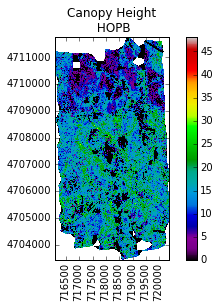

In [11]:
plot_band_array(chm_array,chm_ext,'Canopy Height \n HOPB')
# plt.imshow(chm_array); plt.colorbar()

min: 2.0 m
max: 48.11 m
mean: 14.62 m


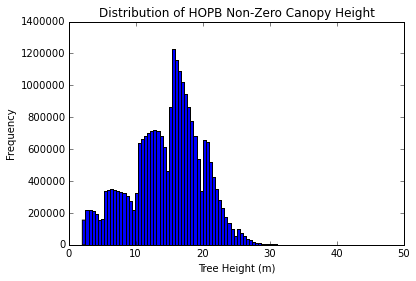

In [12]:
# chm_nonan_array = chm_array[~np.isnan(chm_array)]
chm_nonzero_array = chm_array
chm_nonzero_array[chm_array==0]=np.nan
chm_nonan_array = chm_nonzero_array[~np.isnan(chm_nonzero_array)]
# plt.hist(chm_nonan_array.flatten()) 
plt.hist(chm_nonan_array.flatten(),100) 
plt.title('Distribution of HOPB Non-Zero Canopy Height')
plt.xlabel('Tree Height (m)'); plt.ylabel('Frequency')
# plt.xlim(0,25); plt.ylim(0,4000000)

print('min:',np.amin(chm_nonan_array),'m')
print('max:',round(np.amax(chm_nonan_array),2),'m')
print('mean:',round(np.mean(chm_nonan_array),2),'m')

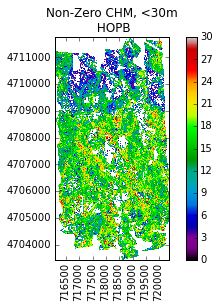

In [13]:
#From the histogram we can see that the majority of the trees are < 30m. 
#Scale the color bar to better display the variation in Canopy Height
plt.imshow(chm_array,extent=chm_ext,clim=(0.0,30))
plt.colorbar(); #plt.set_cmap(colormap); 
plt.title('Non-Zero CHM, <30m \n HOPB'); ax = plt.gca(); 
ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

## Import Aspect Data
**Data Tip:** You can calculate aspect in Python from a digital elevation (or surface) model using the pyDEM package: https://earthlab.github.io/tutorials/get-slope-aspect-from-digital-elevation-model/

In [14]:
aspect_filename = '2016_HOPB_DTM_Aspect.tif'
aspect_dataset = gdal.Open(aspect_filename)
#Display the dataset dimensions:
cols_asp = aspect_dataset.RasterXSize; print('x:',cols)
rows_asp = aspect_dataset.RasterYSize; print('y:',rows)
print('bands:',aspect_dataset.RasterCount)
print('driver:',aspect_dataset.GetDriver().LongName)
print('geotransform:',aspect_dataset.GetGeoTransform())
print('projection:',aspect_dataset.GetProjection())

x: 4274
y: 8339
bands: 1
driver: GeoTIFF
geotransform: (716084.0, 1.0, 0.0, 4711763.0, 0.0, -1.0)
projection: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [15]:
aspect_mapinfo = aspect_dataset.GetGeoTransform()
xMin = aspect_mapinfo[0]
yMax = aspect_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/aspect_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/aspect_mapinfo[5] #divide by pixel height (note sign +/-)
asp_ext = (xMin,xMax,yMin,yMax)
print('Aspect Raster Extent:',asp_ext)

Aspect Raster Extent: (716084.0, 720358.0, 4703424.0, 4711763.0)


In [16]:
#Convert CHM raster to NumPy array
aspect_raster = aspect_dataset.GetRasterBand(1)
# print(aspect_raster)

noDataVal_asp = aspect_raster.GetNoDataValue()
print('No Data Value:',noDataVal_asp)

scaleFactor_asp = chm_raster.GetScale()
print('Scale Factor:',scaleFactor_asp)

asp_stats = aspect_raster.GetStatistics(True,True)
print('Aspect Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (asp_stats[0], asp_stats[1], asp_stats[2], asp_stats[3]))

aspect_array = aspect_dataset.GetRasterBand(1).ReadAsArray(0,0,cols_asp,rows_asp).astype(np.float)
print(aspect_array)

No Data Value: -9999.0
Scale Factor: 1.0
Aspect Statistics: Minimum=0.00, Maximum=360.00, Mean=163.393, StDev=98.623
[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]


In [17]:
#Assign No Data Values to NaN
aspect_array[aspect_array==int(noDataVal_asp)]=np.nan
print('Aspect Array:\n',aspect_array)

Aspect Array:
 [[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


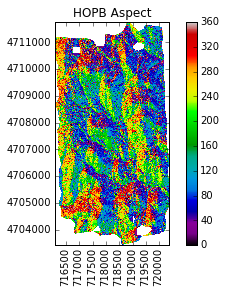

In [18]:
plot_band_array(aspect_array,asp_ext,'HOPB Aspect')

## Threshold Based Raster Classification
Next, we will create a classified raster object. To do this, we need to:
1. Create a matrix containing the threshold ranges and the associated class (category).
2. Use the NumPy ma function to apply the mask to create a new raster.
<p> **North Facing Slopes**: 0-45 $^{\circ}$ & 315-360 $^{\circ}$ ; class=1
<p> **South Facing Slopes**: 135-225 $^{\circ}$ ; class=2

In [19]:
import copy
asp_reclass = copy.copy(aspect_array)
asp_reclass[np.where(((aspect_array>=0) & (aspect_array<=45)) | (aspect_array>=315))] = 1 #North - Class 1
asp_reclass[np.where((aspect_array>=135) & (aspect_array<=225))] = 2 #South - Class 2
asp_reclass[np.where(((aspect_array>45) & (aspect_array<135)) | ((aspect_array>225) & (aspect_array<315)))] = np.nan #W & E - Unclassified

# print(aspect_reclassified.dtype)
# print('Reclassified Aspect Matrix:',asp_reclass.shape)
# print(aspect_reclassified)
print('Min:',np.nanmin(asp_reclass))
print('Max:',np.nanmax(asp_reclass))
print('Mean:',round(np.nanmean(asp_reclass),2))

Min: 1.0
Max: 2.0
Mean: 1.53


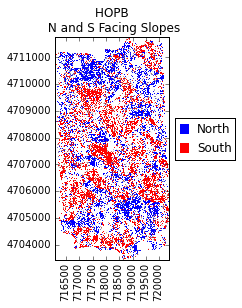

In [20]:
# plot_band_array(aspect_reclassified,asp_ext,'North and South Facing Slopes \n HOPB')
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['blue','red'])
plt.imshow(asp_reclass,extent=asp_ext,cmap=cmapNS)
plt.title('HOPB \n N and S Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label N & S
import matplotlib.patches as mpatches
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), loc='lower left', borderaxespad=0.)

## Test CHM Raster Classification on a Different Dataset (TEAK)

In [21]:
aspect_filename = 'TEAK_lidarAspect.tif'
aspect_dataset = gdal.Open(aspect_filename)
#Display the dataset dimensions:
cols_asp = aspect_dataset.RasterXSize; print('x:',cols)
rows_asp = aspect_dataset.RasterYSize; print('y:',rows)
print('bands:',aspect_dataset.RasterCount)
print('driver:',aspect_dataset.GetDriver().LongName)
print('geotransform:',aspect_dataset.GetGeoTransform())
# print('projection:',aspect_dataset.GetProjection())

aspect_mapinfo = aspect_dataset.GetGeoTransform()
xMin = aspect_mapinfo[0]
yMax = aspect_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/aspect_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/aspect_mapinfo[5] #divide by pixel height (note sign +/-)
asp_ext = (xMin,xMax,yMin,yMax)
print('TEAK Aspect Raster Extent:',asp_ext)

#Convert CHM raster to NumPy array
aspect_raster = aspect_dataset.GetRasterBand(1)
noDataVal_asp = aspect_raster.GetNoDataValue()
print('No Data Value:',noDataVal_asp)
scaleFactor_asp = chm_raster.GetScale()
print('Scale Factor:',scaleFactor_asp)
asp_stats = aspect_raster.GetStatistics(True,True)
print('TEAK Aspect Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (asp_stats[0], asp_stats[1], asp_stats[2], asp_stats[3]))
aspect_array = aspect_dataset.GetRasterBand(1).ReadAsArray(0,0,cols_asp,rows_asp).astype(np.float)
print(aspect_array)

#Assign No Data Values to NaN
aspect_array[aspect_array==int(noDataVal_asp)]=np.nan
# print('Aspect Array:\n',aspect_array)

x: 4274
y: 8339
bands: 1
driver: GeoTIFF
geotransform: (325963.0, 1.0, 0.0, 4103482.0, 0.0, -1.0)
TEAK Aspect Raster Extent: (325963.0, 330237.0, 4095143.0, 4103482.0)
No Data Value: -9999.0
Scale Factor: 1.0
TEAK Aspect Statistics: Minimum=0.00, Maximum=359.99, Mean=139.903, StDev=87.695
[[ 250.06430054  257.85830688  262.95651245 ...,  130.26113892
   124.93721008  124.00881958]
 [ 258.81506348  258.72476196  256.93389893 ...,  128.81915283
   122.07086182  125.01222992]
 [ 271.61352539  264.06555176  257.58831787 ...,  131.73789978
   122.91130829  123.45059204]
 ..., 
 [ 102.16982269  116.63002777  118.32381439 ...,  112.23679352
   119.87068939  129.57875061]
 [  98.08813477  106.55480194  107.11672211 ...,  110.36571503
   116.52466583  125.59832764]
 [  94.95069122   94.69854736   89.70905304 ...,  108.84827423
   113.43959808  122.22781372]]


Min: 1.0
Max: 2.0
Mean: 1.67


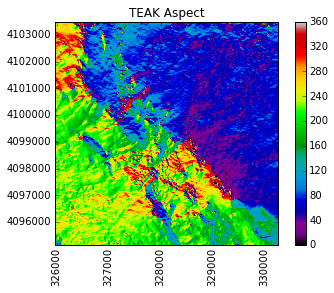

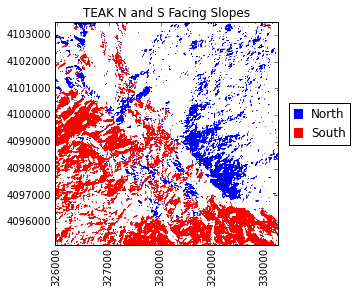

In [22]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

plot_band_array(aspect_array,asp_ext,'TEAK Aspect')
ax = plt.gca(); forceAspect(ax,aspect=1) # ax.set_aspect('equal')

asp_reclass = copy.copy(aspect_array)
asp_reclass[np.where(((aspect_array>=0) & (aspect_array<=45)) | (aspect_array>=315))] = 1 #North - Class 1
asp_reclass[np.where((aspect_array>=135) & (aspect_array<=225))] = 2 #South - Class 2
asp_reclass[np.where(((aspect_array>45) & (aspect_array<135)) | ((aspect_array>225) & (aspect_array<315)))] = np.nan #W & E - Unclassified

# print(aspect_reclassified.dtype)
# print('Reclassified Aspect Matrix:',asp_reclass.shape)
# print(aspect_reclassified)
print('Min:',np.nanmin(asp_reclass))
print('Max:',np.nanmax(asp_reclass))
print('Mean:',round(np.nanmean(asp_reclass),2))

# plot_band_array(aspect_reclassified,asp_ext,'North and South Facing Slopes \n HOPB')
from matplotlib import colors
plt.figure(); #ax = plt.subplots()
cmapNS = colors.ListedColormap(['blue','red'])
plt.imshow(asp_reclass,extent=asp_ext,cmap=cmapNS)
plt.title('TEAK N and S Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
forceAspect(ax,aspect=1) # ax.set_aspect('auto')

# Create custom legend to label N & S
import matplotlib.patches as mpatches
blue_box = mpatches.Patch(color='blue', label='North')
red_box = mpatches.Patch(color='red', label='South')
ax.legend(handles=[blue_box,red_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.45), loc='lower left', borderaxespad=0.)

## Export classified raster to a geotif

In [23]:
# %load ../hyperspectral_hdf5/array2raster.py
"""
Array to Raster Function from https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html)
"""

import gdal, osr #ogr, os, osr
import numpy as np


def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [24]:
# array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)
array2raster('teak_nsAspect.tif',(xMin,yMin),1,1,asp_reclass[::-1])

## Challenge 1: Document Your Workflow 
1. Look at the code that you created for this lesson. Now imagine yourself months in the future. Document your script so that your methods and process is clear and reproducible for yourself or others to follow in the future. 
2. In documenting your script, synthesize the outputs. Do they tell you anything about the vegetation structure at the field site? 

## Challenge 2: Try out other Classifications
Create the following threshold classified outputs:
1. A raster where NDVI values are classified into the following categories:
    * Low greenness: NDVI < 0.3
    * Medium greenness: 0.3 < NDVI < 0.6
    * High greenness: NDVI > 0.6
2. A raster where canopy height is classified. Explore the CHM data and choose threshold values that make sense given the distribution of values in the data (Hint: look at the CHM histogram you made). 

Be sure to document your workflow as you go using Jupyter Markdown cells. When you are finished, explore your outputs to HTML  by selecting File > Download As > HTML (.html). Save the file as LastName_Tues_classifyThreshold.html. Add this to the Tuesday directory in your DI17-NEON-participants Git directory and push them to your fork in GitHub. Merge with the central repository using a pull request. 

Min: 1.0
Max: 4.0
Mean: 1.98


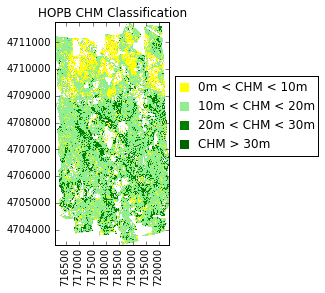

In [25]:
## Challenge 2 - Canopy Height Classification Solution
# Classify HOPB CHM into the following classes:
# 1. 0-10m
# 2. 10-20m
# 3. 20-30m
# 4. > 30m

chm_reclass = copy.copy(chm_array)
chm_reclass[np.where((chm_array>0) & (chm_array<=10))] = 1 #CHM = 0-10m - Class 1
chm_reclass[np.where((chm_array>10) & (chm_array<=20))] = 2 #CHM = 10-20m - Class 2
chm_reclass[np.where((chm_array>20) & (chm_array<=30))] = 3 #CHM = 20-30m - Class 3
chm_reclass[np.where(chm_array>30)] = 4 #CHM > 30m - Class 4

print('Min:',np.nanmin(chm_reclass))
print('Max:',np.nanmax(chm_reclass))
print('Mean:',round(np.nanmean(chm_reclass),2))

plt.figure(); #ax = plt.subplots()
cmapCHM = colors.ListedColormap(['yellow','lightgreen','green','darkgreen'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('HOPB CHM Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
# forceAspect(ax,aspect=1) # ax.set_aspect('auto')

# Create custom legend to label N & S
import matplotlib.patches as mpatches
yellow_box = mpatches.Patch(color='yellow', label='0m < CHM < 10m')
lightgreen_box = mpatches.Patch(color='lightgreen', label='10m < CHM < 20m')
green_box = mpatches.Patch(color='green', label='20m < CHM < 30m')
darkgreen_box = mpatches.Patch(color='darkgreen', label='CHM > 30m')

ax.legend(handles=[yellow_box,lightgreen_box,green_box,darkgreen_box],handlelength=0.7,bbox_to_anchor=(1.05, 0.4), loc='lower left', borderaxespad=0.)

## Scratch / Test Code

In [ ]:
#Test out slope reclassification on subset of HOPB aspect array:
import copy
aspect_subset = aspect_array[1000:1005,1000:1005]
print(aspect_subset)

asp_sub_reclass = copy.copy(aspect_subset)
asp_sub_reclass[np.where(((aspect_subset>=0) & (aspect_subset<=45)) | (aspect_subset>=315))] = 1 #North - Class 1
asp_sub_reclass[np.where((aspect_subset>=135) & (aspect_subset<=225))] = 2 #South - Class 2
asp_sub_reclass[np.where(((aspect_subset>45) & (aspect_subset<135)) | ((aspect_subset>225) & (aspect_subset<315)))] = np.nan #W & E - Unclassified

print('Reclassified Aspect Subset:\n',asp_sub_reclass)